In [2]:
from robot_properties_solo.solo12wrapper import Solo12Config
import pinocchio as pin
from scipy.spatial.transform import Rotation
from mim_data_utils import DataReader
import matplotlib.pylab as plt
import numpy as np

# np.set_printoptions(suppress=True, precision=4, sign=' ')

plt.rcParams['figure.dpi'] = 180  # makes plots bigger, default = 72.0

# Read, Filter, and Calculate Data

In [3]:
pin_robot = Solo12Config.buildRobotWrapper()
reader = DataReader('reactive stepping/2021-08-02_10-48-13.mds')

In [4]:
reader.data.keys()

dict_keys(['x_des', 'xd_des', 'w_com', 'kc', 'dc', 'kb', 'db', 'joint_positions', 'joint_velocities', 'slider_positions', 'imu_gyroscope', 'zero_sliders', 'control_time', 'q', 'dq', 'com', 'rel_eff', 'vicon_leg_hl', 'F', 'dx_des', 'tau'])

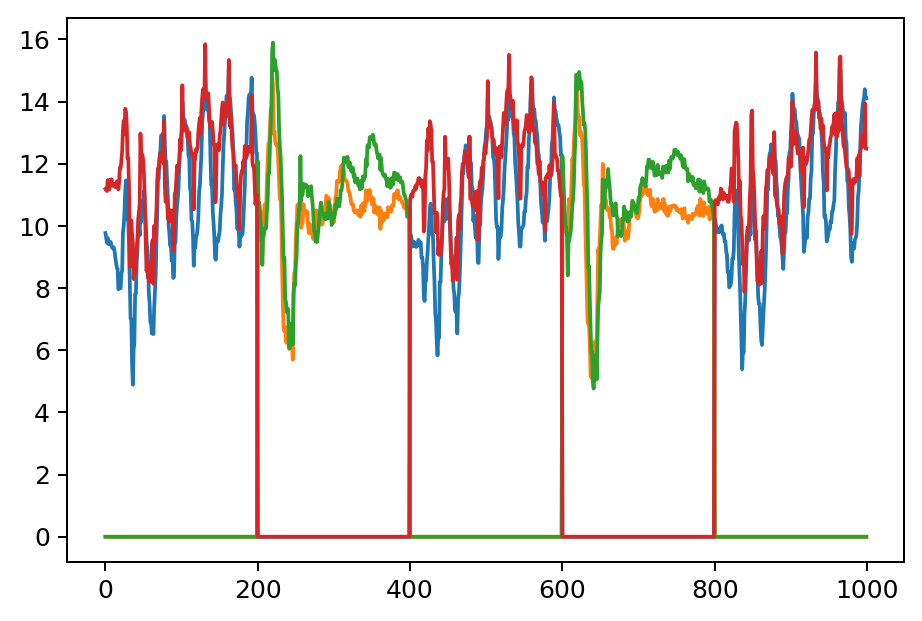

In [5]:
plt.plot(reader.data['F'][1000:2000, (2, 5, 8, 11)])

In [6]:
reader_q = reader.data['q']
reader_dq = reader.data['dq']
reader_tau = reader.data['tau']
reader_vicon_leg = reader.data['vicon_leg_hl']
reader_imu = reader.data['imu_gyroscope']

calculated_f = np.empty((reader_q.shape[0], 4, 3))
calculated_omi = np.empty((reader_q.shape[0], 3))

In [13]:
print(reader_q.shape)

(20003, 19)


In [22]:
# calculate f
# for ms in range(reader_q.shape[0]):
for ms in range(20003):
    q = reader_q[ms]
    dq = reader_dq[ms]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(
            frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6 + 3 * i:9 + 3 * i].T) * -1
        h = pin_robot.nle(q, dq)
        F = np.hstack((np.zeros(6), reader_tau[ms][6:]))
        calculated_f[ms, i] = J_inv @ ((F - h)[6 + 3 * i:9 + 3 * i])

# plt.plot(calculated_f[:, :, 2])

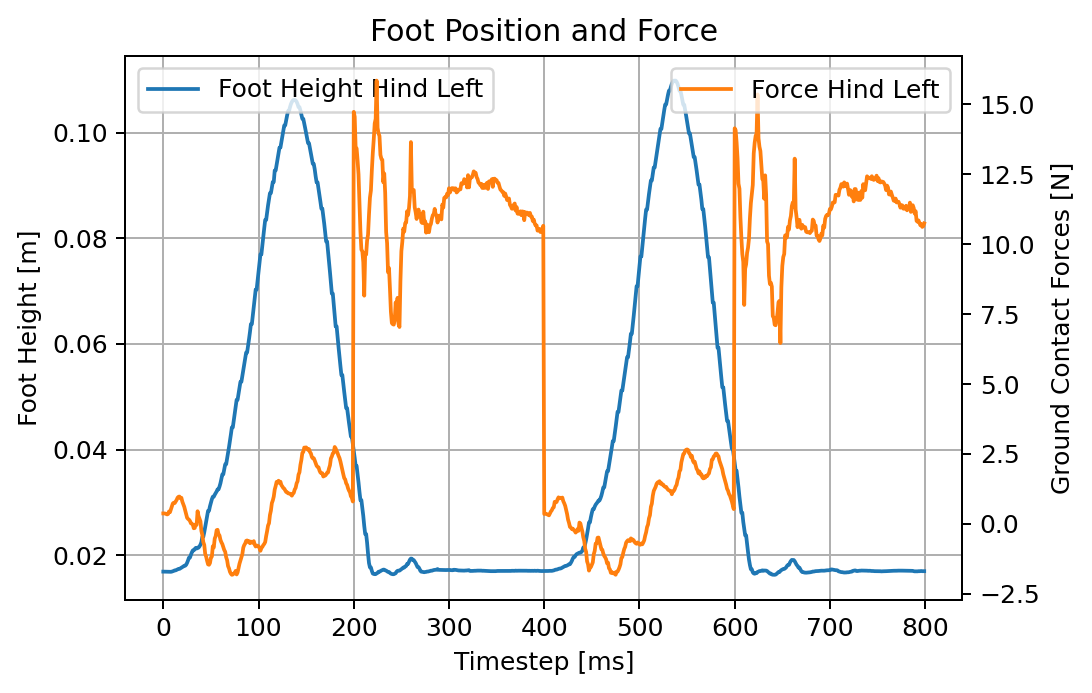

In [50]:
s = slice(10200, 11000)

plt.plot(reader_vicon_leg[s, 2], color='C0', label='Foot Height Hind Left') 
plt.ylabel('Foot Height [m]')
plt.xlabel('Timestep [ms]')
plt.legend(loc='upper left')
plt.grid()

t = plt.twinx()
t.plot(calculated_f[s, 2, 2], color='C1', label='Force Hind Left')
t.set_ylabel('Ground Contact Forces [N]')
t.legend(loc='upper right')

# t = plt.twinx()
# t.plot(reader_tau[s, 8], color='C2', label='tau')
# t.legend()

plt.title("Foot Position and Force")
# plt.legend()


plt.show()

In [ ]:
plt.plot(rea)

## M @ ddq

In [15]:
c_ddq = np.gradient(reader_dq, axis=0)
print(c_ddq.shape)
M = np.hstack((np.zeros(6), list(e.mass for e in pin_robot.model.inertias[2:])))
print(M.shape)

(20003, 18)
(18,)


In [16]:
with_ddq = np.empty((reader_q.shape[0], 4, 3))

for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    dq = reader_dq[ms]
    ddq = c_ddq[ms]
    pin_robot.computeJointJacobians(q)
    
    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):             
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6+3*i:9+3*i].T)
        h = pin_robot.nle(q, dq)
        t = np.hstack((np.zeros(6), reader_tau[ms][6:]))
        Md = M.T @ ddq
        with_ddq[ms, i] = J_inv @ ((Md + h - t)[6+3*i:9+3*i])

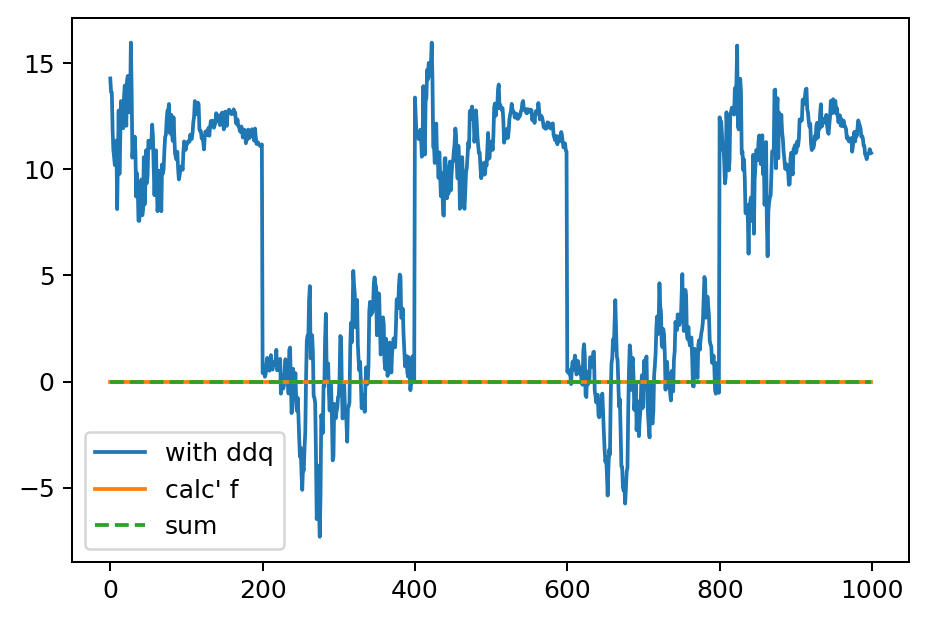

In [17]:
s = slice(12000, 13000)
plt.plot(with_ddq[s, 2, 2], label='with ddq')
plt.plot(calculated_f[s, 2, 2], label='calc\' f')
plt.plot(np.sum(calculated_f[s, 1:3, 2], axis=1)/2, ls='--', label='sum')
plt.legend()


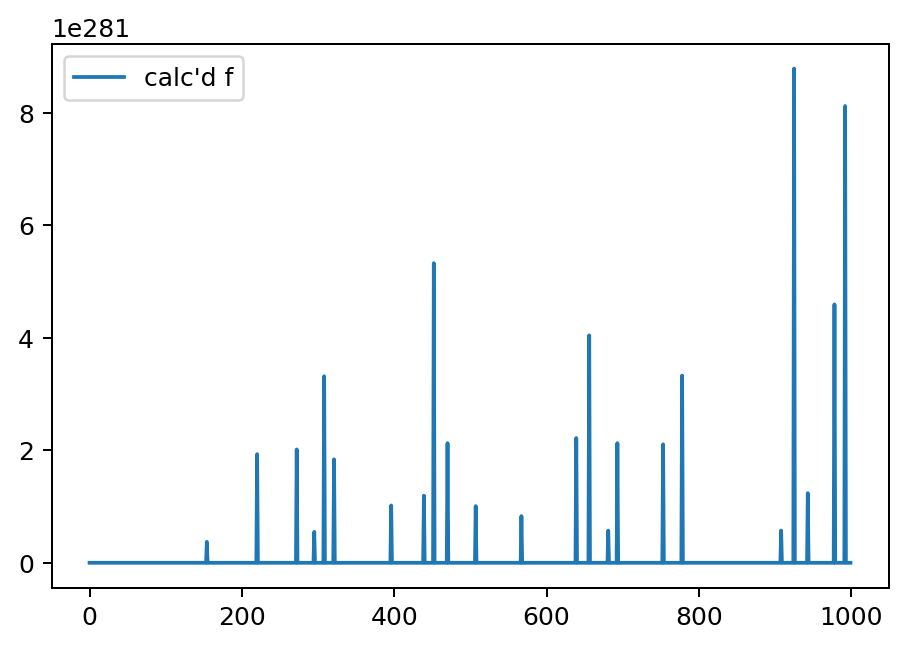

In [19]:
s = slice(1000, 2000)
plt.plot(calculated_f[s, 2, 2], label="calc'd f")
plt.legend();

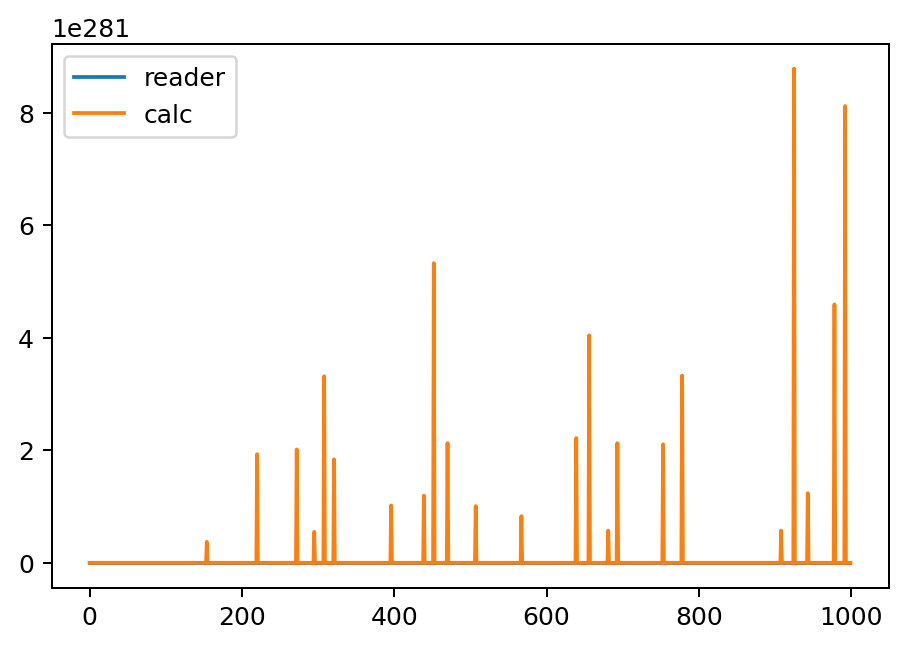

In [20]:
s = slice(1000, 2000)
plt.plot(reader.data['F'][s, 8], color='C0', label='reader')
# plt.legend()
# t = plt.twinx()
plt.plot(calculated_f[s, 2, 2], color='C1', label='calc')
plt.legend()

# Plot Data

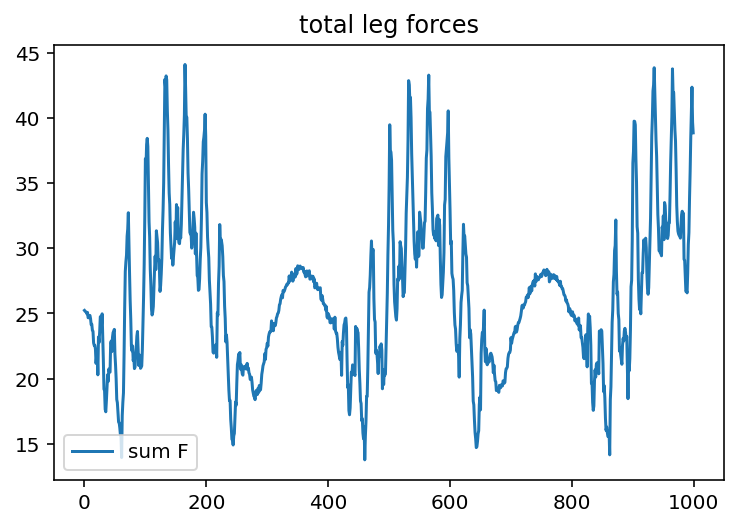

In [13]:
s = slice(5000, 6000)
plt.plot(np.sum(calculated_f[s, :, 2], axis=1), label="sum F")
plt.title('total leg forces')
plt.legend();

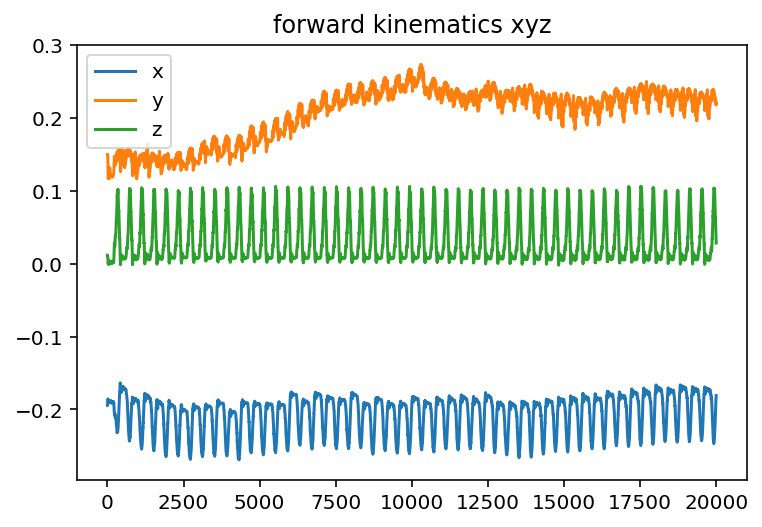

In [14]:
# plot xyz of forward kinematics
forwardK = np.empty((reader_q.shape[0], 3))
# for i_omi in range(1, 14):
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    # dq = all_dq[ms]
    pin_robot.computeJointJacobians(q)
#     pin_robot.forwardKinematics(q)
    pin_robot.framesForwardKinematics(q)
    forwardK[ms] = pin_robot.data.oMf[pin_robot.model.getFrameId('HL_ANKLE')].translation

plt.plot(forwardK)
plt.legend('xyz')
plt.title('forward kinematics xyz');

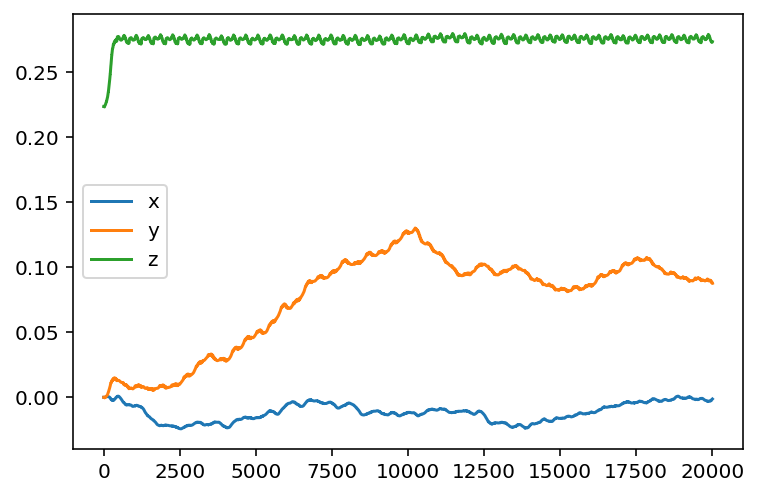

In [15]:
plt.plot(reader_q[:, :3])
plt.legend('xyz');

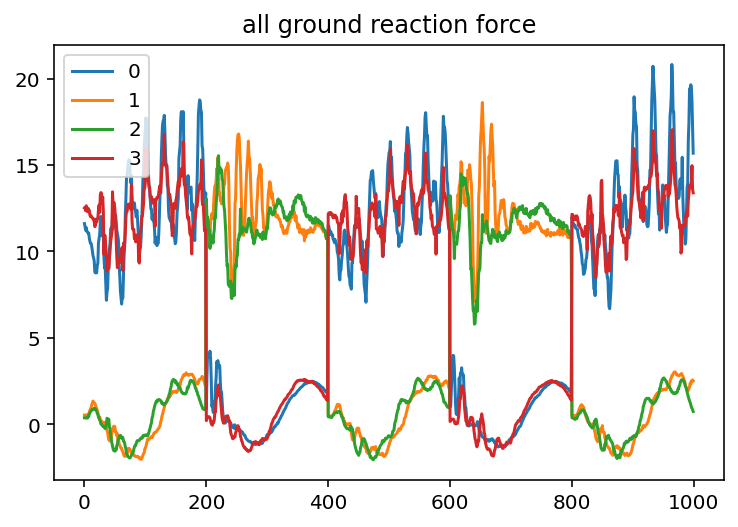

In [16]:
# plot GRF
plt.plot(calculated_f[1000:2000, :, 2])
plt.title('all ground reaction force')
plt.legend(range(4))

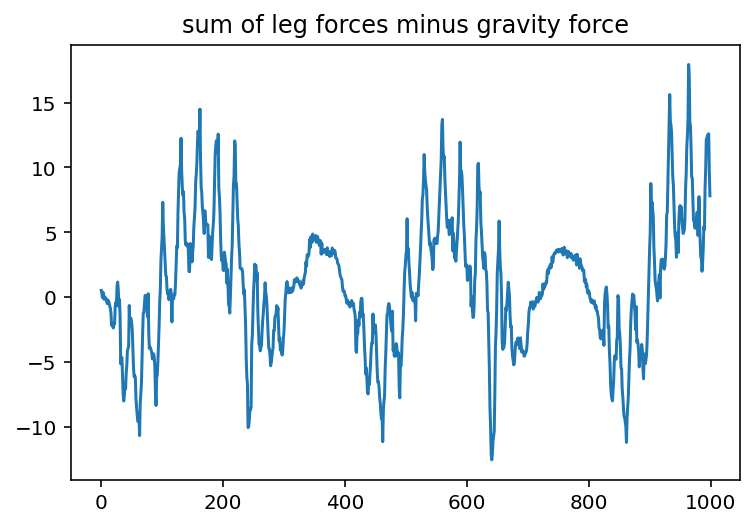

In [17]:
# plot the sum of all leg forces
m_robot = np.sum([i.mass for i in pin_robot.model.inertias])
plt.plot(np.sum(calculated_f[1000:2000, :, 2], axis=1) - m_robot * 9.81)
plt.title("sum of leg forces minus gravity force");

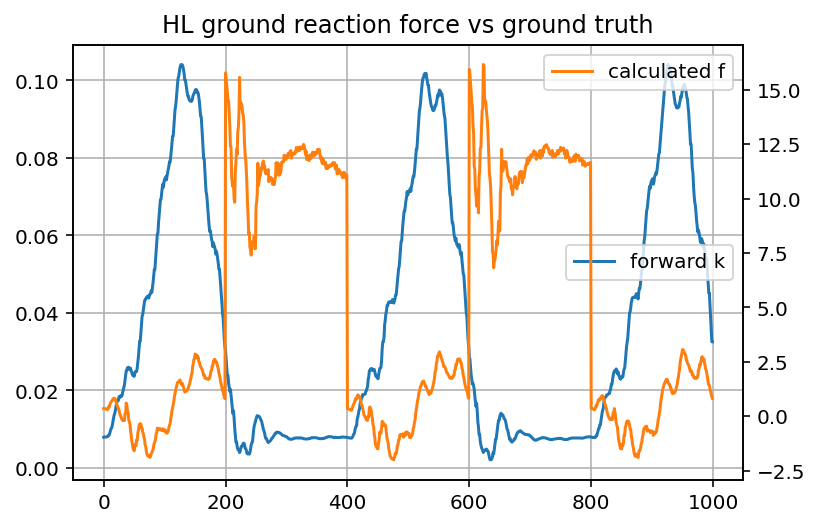

In [23]:
# compare calculated f and z values of forward kinematics
s = slice(3000, 4000)

plt.plot(forwardK[s, 2], label='forward k', color='C0')
plt.legend()
plt.grid()

tw = plt.twinx()
tw.plot(calculated_f[s, 2, 2], label='calculated f', color='C1')
# tw.grid(None)

# tw.plot(reader.data['joint_velocities'][s, 8], color='C2', label='joint vel')
tw.legend()



plt.title('HL ground reaction force vs ground truth')
plt.show()

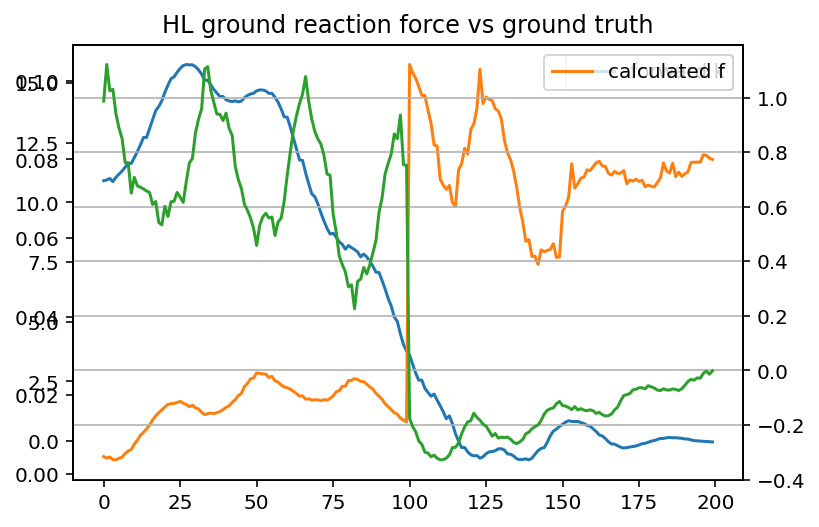

In [24]:
s = slice(3100, 3300)

plt.plot(forwardK[s, 2], label='forward k', color='C0')
plt.legend()

tw = plt.twinx()
tw.plot(calculated_f[s, 2, 2], label='calculated f', color='C1')

# tw.plot(reader.data['joint_velocities'][s, 8], color='C2', label='joint vel')
tw.legend()

tw = plt.twinx()
tw.plot(reader.data['tau'][s, 8], label='tau', color='C2')

plt.title('HL ground reaction force vs ground truth')
plt.grid()

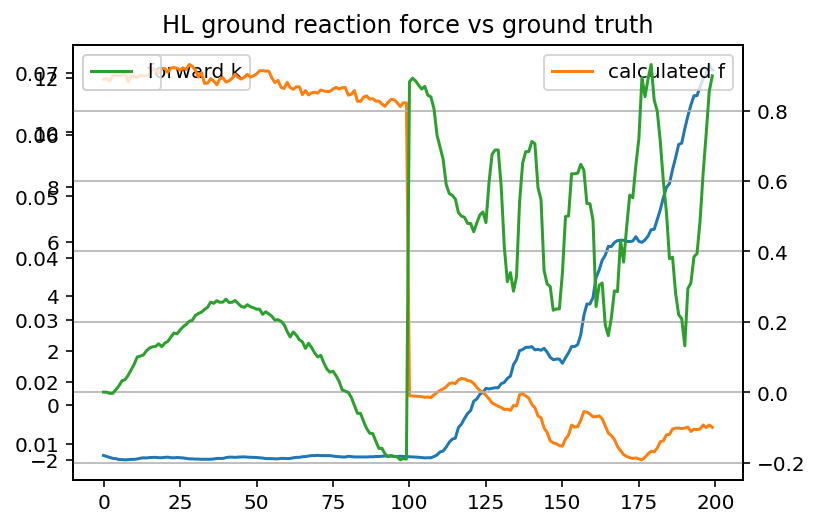

In [27]:
s = slice(3300, 3500)

plt.plot(forwardK[s, 2], label='forward k', color='C0')
plt.legend()

tw = plt.twinx()
tw.plot(calculated_f[s, 2, 2], label='calculated f', color='C1')

# tw.plot(reader.data['joint_velocities'][s, 8], color='C2', label='joint vel')
tw.legend()

tw = plt.twinx()
tw.plot(reader.data['tau'][s, 8], label='tau', color='C2')

plt.title('HL ground reaction force vs ground truth')
plt.grid()

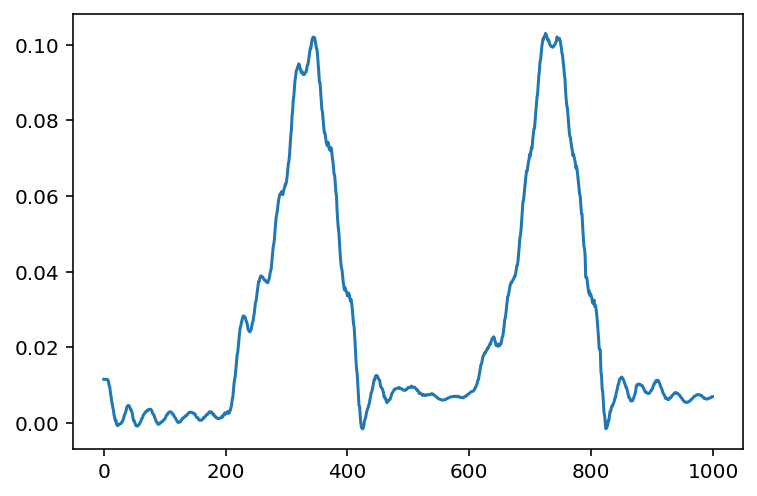

In [27]:
plt.plot(forwardK[0:1000, 2])

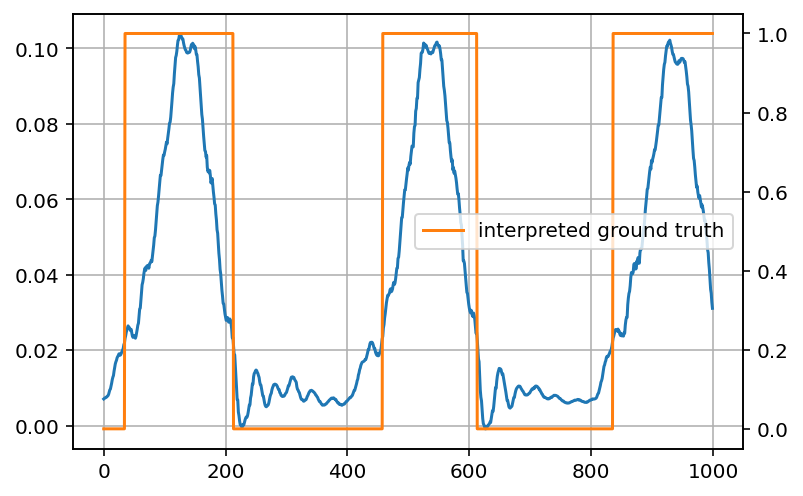

In [43]:
plt.plot(forwardK[1000:2000, 2], label='forward kinematics foot z', color='C0')
plt.grid()
t = plt.twinx()
t.plot(np.where(forwardK[1000:2000, 2] > 0.023, 1, 0), label='interpreted ground truth', color='C1')
plt.plot()

plt.legend()

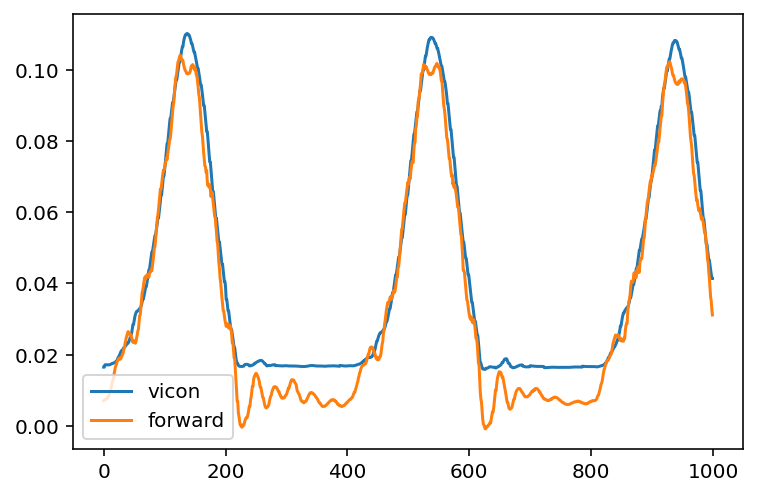

In [44]:
slice_compare_viconforwardK = slice(1000,2000)
plt.plot(reader_vicon_leg[slice_compare_viconforwardK, 2], label='vicon')
plt.plot(forwardK[slice_compare_viconforwardK, 2], label='forward')
plt.legend()

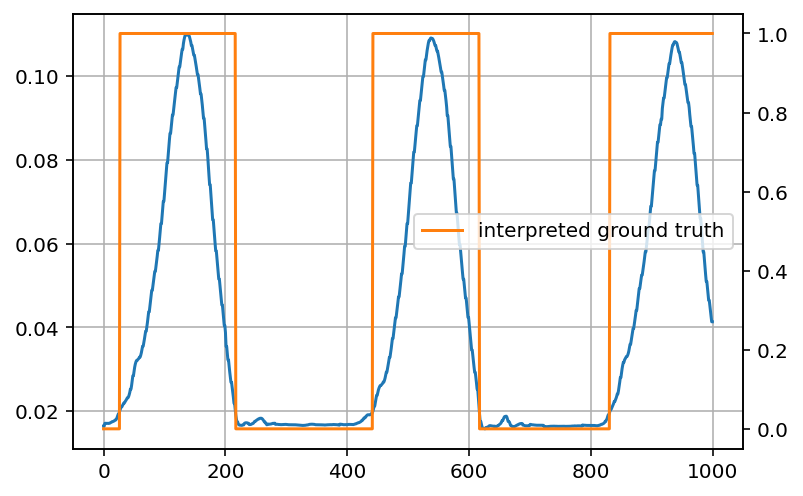

In [47]:
plt.plot(reader_vicon_leg[1000:2000, 2], label='forward kinematics foot z', color='C0')
plt.grid()

t = plt.twinx()
t.plot(np.where(reader_vicon_leg[1000:2000, 2] > 0.02, 1, 0), label='interpreted ground truth', color='C1')
plt.plot()
plt.legend()

Text(0.5, 1.0, 'body')

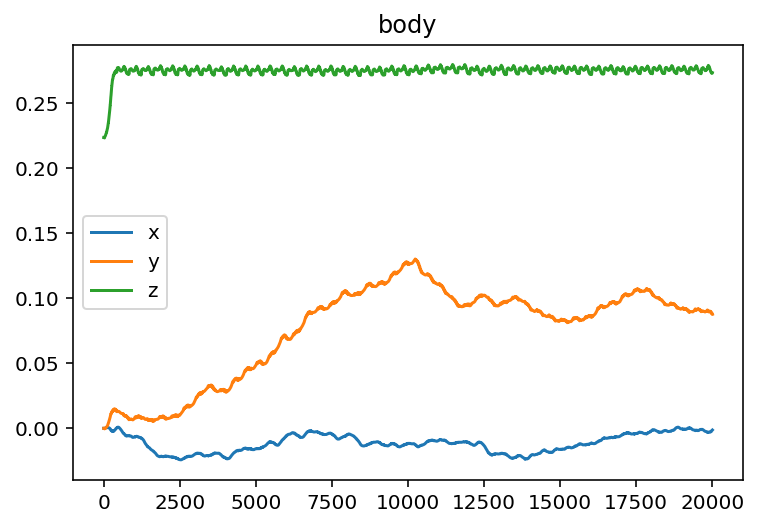

In [48]:
plt.plot(reader_q[:, :3])
plt.legend('xyz')
plt.title('body')

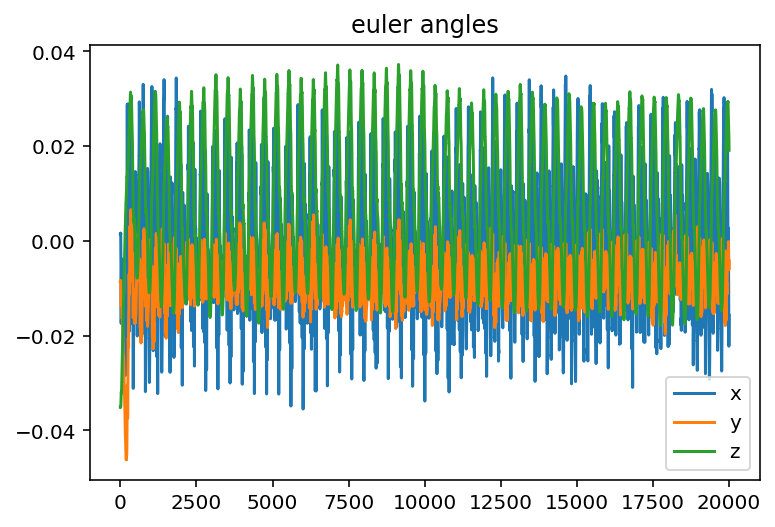

In [49]:
calculated_euler_angles = Rotation.from_quat(reader_q[:, 3:7]).as_euler('xyz')
plt.plot(calculated_euler_angles)
plt.title('euler angles')
plt.legend('xyz')

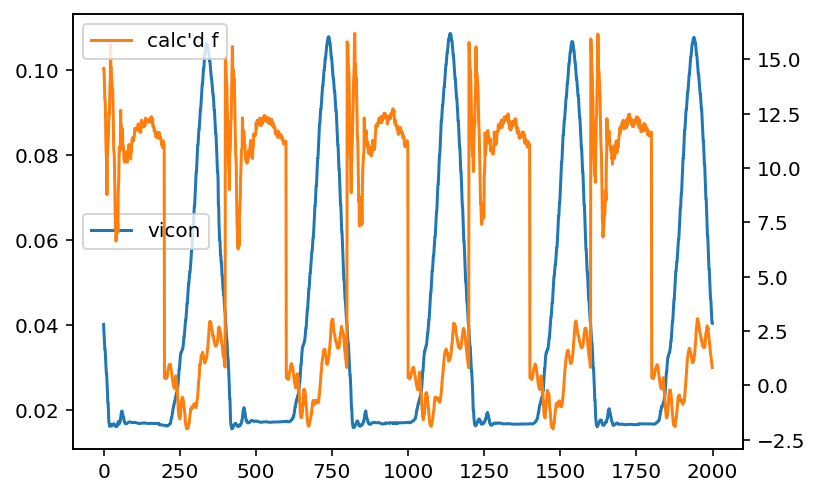

In [58]:
s = slice(2000, 4000)
plt.plot(reader_vicon_leg[s, 2], label='vicon', color='C0')
plt.legend()
t = plt.twinx()
t.plot(calculated_f[s, 2, 2], label='calc\'d f', color='C1')
t.legend();

In [31]:
np.sum([i.mass for i in pin_robot.model.inertias]) * 9.81
# 24.525027369900005

24.525027369900005